Davies-Bouldin Index: 1.308672004224051


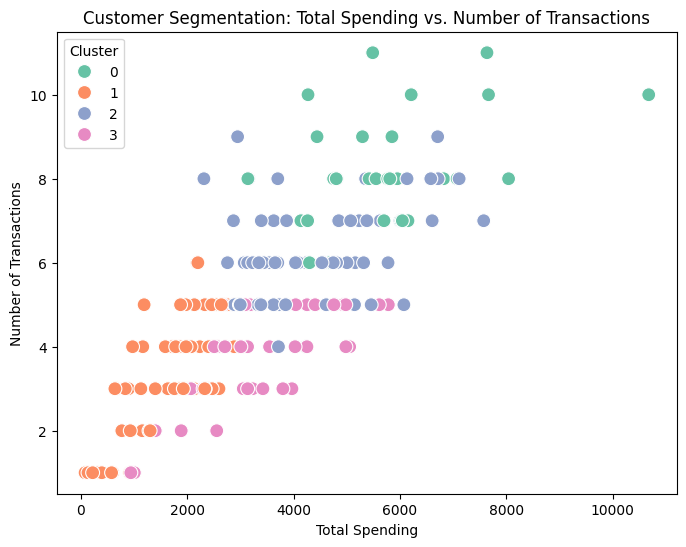


Cluster Summary:
   Cluster  AvgSpending  AvgTransactions  AvgDiversity
0        0  5783.234643         8.250000      7.928571
1        1  1712.438154         3.338462      3.292308
2        2  4377.232813         6.218750      6.062500
3        3  3252.705000         3.666667      3.571429


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Convert dates to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Aggregate transactional data for each customer
agg_data = transactions.groupby("CustomerID").agg(
    TotalSpending=("TotalValue", "sum"),
    NumTransactions=("TransactionID", "count"),
    AvgTransactionValue=("TotalValue", "mean"),
    ProductDiversity=("ProductID", pd.Series.nunique)
).reset_index()

# Merge aggregated data with customer demographics
customers = pd.merge(customers, agg_data, on="CustomerID", how="inner")

# Convert categorical columns to numerical
customers['Region'] = customers['Region'].astype('category').cat.codes

# Prepare data for clustering
features = ['Region', 'TotalSpending', 'NumTransactions', 'AvgTransactionValue', 'ProductDiversity']
X = customers[features]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means Clustering
k = 4  # You can experiment with different values of k
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Assign clusters to customers
customers['Cluster'] = clusters

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X_scaled, clusters)
print(f"Davies-Bouldin Index: {db_index}")

# Visualize Clusters (Scatter Plot for Two Features)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=customers['TotalSpending'], 
    y=customers['NumTransactions'], 
    hue=customers['Cluster'], 
    palette='Set2', 
    s=100
)
plt.title("Customer Segmentation: Total Spending vs. Number of Transactions")
plt.xlabel("Total Spending")
plt.ylabel("Number of Transactions")
plt.legend(title="Cluster")
plt.show()

# Save clustering results
customers.to_csv("Customer_Segments.csv", index=False)

# Summary of clusters
cluster_summary = customers.groupby('Cluster').agg(
    AvgSpending=('TotalSpending', 'mean'),
    AvgTransactions=('NumTransactions', 'mean'),
    AvgDiversity=('ProductDiversity', 'mean')
).reset_index()

print("\nCluster Summary:")
print(cluster_summary)